In [3]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
import os
# fastica, picard, infomax. Picard maybe better

In [18]:
def filter(data):
    data = signal.detrend(data, axis = 0)

    # Define the filter parameters
    lowcut = 0.5
    highcut = 38
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')

    # Apply the filter to each column of the DataFrame
    df_filt = lfilter(b, a, data, axis = 0)

    # Define the filter parameters
    lowcut = 48
    highcut = 52
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='bandstop')

    # Apply the filter to each column of the DataFrame
    df_filt1 = lfilter(b, a, df_filt, axis = 0)
    
    return df_filt1

In [5]:
filename_list = [
'EEGdata-2024-144--14-24-41',
'EEGdata-2024-144--14-47-17',
'EEGdata-2024-144--14-56-37',
'EEGdata-2024-144--15-28-30',
'EEGdata-2024-144--15-54-35',
'EEGdata-2024-148--14-42-07',
'EEGdata-2024-148--14-48-17',
'EEGdata-2024-148--14-55-39',
'EEGdata-2024-149--15-20-21',
'EEGdata-2024-149--15-35-40',
'EEGdata-2024-149--15-45-38',
'EEGdata-2024-149--15-57-42',
'EEGdata-2024-149--16-41-44',
'EEGdata-2024-150--14-48-32',
'EEGdata-2024-150--14-55-28',
'EEGdata-2024-150--15-01-30',
'EEGdata-2024-150--15-07-57',
'EEGdata-2024-150--15-14-53',
'EEGdata-2024-150--15-30-23',
'EEGdata-2024-150--15-36-40',
'EEGdata-2024-150--15-42-38',
'EEGdata-2024-156--14-35-07',
'EEGdata-2024-156--14-42-54',
'EEGdata-2024-156--14-51-06',
'EEGdata-2024-156--14-58-57',
'EEGdata-2024-156--15-06-57',
'EEGdata-2024-156--15-21-50',
'EEGdata-2024-156--15-27-22',
'EEGdata-2024-162--11-15-01',
'EEGdata-2024-162--11-20-53',
'EEGdata-2024-162--11-28-38',
'EEGdata-2024-162--11-35-23']

In [20]:
def ICA_filtering(file_name1):
    # Select file from measurement
    # Change next to lines if needed
    path = "C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/"
    filename = file_name1

    df = pd.read_csv(path+filename + ".csv", sep=",")
    end = df.shape[0] # Remove 5 samples buffer at the end
    fs = 250
    df = df.iloc[:end, :8] # Select 72000 samples from 8 channels

    #Apply the filters and DC component removal
    df = filter(df)

    # Constants
    num_components = 8
    allOutputs = df

    channels = df.T

    # create mne_info object
    ch_names =        ['Fz', 
                'C3',  'Cz',  'C4', 
                    'Pz', 
                'PO7', 'Oz',  'PO8']

    ch_type = ['eeg' for i in range(8)]
    mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

    #create mne.raw object
    raw = mne.io.RawArray(channels, mne_info)
    raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

    #actual code
    raw.filter(0.5, 38)

    # ICA model
    ica = mne.preprocessing.ICA(method='picard', fit_params=dict(ortho=False,extended=True), n_components=num_components, random_state=0)
    #ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True), n_components=num_components, random_state=0)
    ica.fit(raw) # fit the model on the data

    bad_channels_l = []
    i = 0

    # Cycle through exclude indices from 0 to 7
    for exclude_index in range(8):
        dif_l1 = []
        # Change the indices which needs to be removed based on the plots and bad channels
        ica.exclude = [exclude_index]  # indices chosen based on various plots above

        # ica.apply() changes the Raw object in-place, so let's make a copy first:
        reconst_raw = raw.copy()
        ica.apply(reconst_raw)

        # Transpose to recreate the original shape
        raw_array = raw[:][0].T
        reconst_raw_array = reconst_raw[:][0].T

        for channel in range(8):
            for j in range (6):
                # assign raw and reconstructed signal to variables
                signal1 = raw_array[12000*j : 12000*(j+1),channel]
                signal2 = reconst_raw_array[12000*j : 12000*(j+1),channel]

                # calculate the minimum and maximum of both signals to determine peaks
                max1 = np.max(signal1)
                max2 = np.max(signal2)
                min1 = np.min(signal1)
                min2 = np.min(signal2)

                # calculate variance 
                vars1 = np.var(signal1)
                vars2 = np.var(signal2)

                # calculate standard deviation 
                std1 = np.std(signal1)
                std2 = np.std(signal2)

                print(std1)

                # # Calculate the difference betweeen man and min of both signals
                dif1 = max1 - min1
                dif2 = max2 - min2

                # # Append to list
                # dif_l1.append(dif2-dif1)

                # use combination of amplitude difference, variance difference and sd difference to determine faulty channels
                if std1 - std2 > 9 or dif2*3.5 < dif1 or dif1 - dif2 > 200 and std2 >20:
                    bad_channels_l.append(i)
                    
        # # plot the original and ICA filtered signal
        # x1 = np.linspace(0, end/fs, end, endpoint=True)

        # fig, axs = plt.subplots(8, figsize=(10 , 5))
        # fig.suptitle(f'EEG signals channel {exclude_index} excluded')
        # for i in range(8):
        #     # axs[i].plot(x1[1000:],raw_array[1000:,i])
        #     # axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
        #     axs[i].plot(x1[:],raw_array[:,i])
        #     axs[i].plot(x1[:],reconst_raw_array[:,i])
        #     axs[i].set_xlabel('Time (seconds)')
        #     axs[i].set_ylabel(f'Channel {i+1}')

        # plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
        # plt.show()

        i += 1
        
    # Change the indices which needs to be removed based on the plots and bad channels
    ica.exclude = bad_channels_l  # indices chosen based on various plots above

    # ica.apply() changes the Raw object in-place, so let's make a copy first:
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)

    # Transpose to recreate the original shape
    raw_array = raw[:][0].T
    reconst_raw_array = reconst_raw[:][0].T

    # plot the original and ICA filtered signal
    x1 = np.linspace(0, end/fs, end, endpoint=True)

    fig, axs = plt.subplots(8, figsize=(10 , 5))
    fig.suptitle('EEG signals')
    for i in range(8):
        axs[i].plot(x1[1000:],raw_array[1000:,i])
        axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
        # axs[i].plot(x1[:],raw_array[:,i])
        # axs[i].plot(x1[:],reconst_raw_array[:,i])
        axs[i].set_xlabel('Time (seconds)')
        axs[i].set_ylabel(f'Channel {i+1}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

    # Convert ICA signal to csv file and add columns which were removed before ICA
    ICA_data = pd.DataFrame(reconst_raw_array)

    # Add columns that were removed
    df = pd.read_csv(path+filename + ".csv", sep=",")
    columns_add = df[['Counter', 'Validation', 'Label']] # select the last three columns to be added

    # Rename the columns of df2 to correspond to the first 8 columns of df1
    ICA_data.columns = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

    # Adding the last three columns to ICA_data
    ICA_data = pd.concat([ICA_data, columns_add], axis=1)

    # Convert to csv
    ICA_data.to_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/" +filename + "_ICA.csv", index = False)

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
35.53132496236246
10.769663717497584
11.386551235466168
11.177414432459175
22.663794852193213
19.95819316048699
16.45330479219068
11.603819725053423
11.299642591345862
10.906346374703247
30.732241510230484
25.860382031849745
93.05778439155075
12.047662114944304
12.010431439422547
11.563907976305085
22.398244735826914
19.662707355907255
154.26772101770587
9.163934374611319
9.375255997827052
9.479008069130002
18.958363972371867
16.22139634040642
178.28336411417476
20.131979904463094
16.724350427082506
14.462729168064874
278.3109701205066
242.11054461000762
51.175996911780416
9.383638714031635
9.061396103615085
9.030985429634505
13.87751814130196
12.304892861439374
79.07257034568676
11.159060985612834
10.815282412208443
10.67701970330347
73.60118143935343
61.177603492358266
27.395016203627222
25.68575783371637
23.341714

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


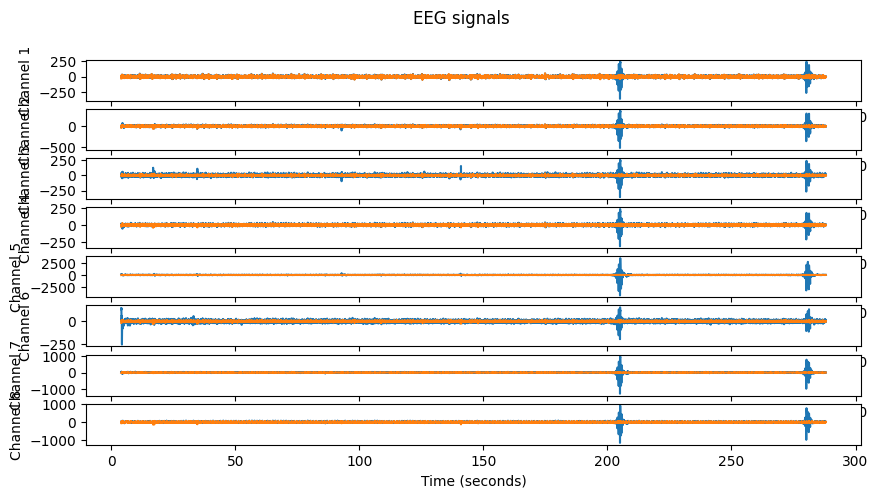

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
15.831468171319926
14.22660115111665
13.877738201003869
13.357048572309623
12.655057379344264
12.685500456332115
30.75281926001064
31.821892857458764
29.476945773932155
27.85644133828795
26.0034691355345
24.54462392846347
124.20121084253228
16.58714743090008
16.39195129989545
15.491800684207258
15.897725863858362
16.403027218158307
116.70143832131232
8.878488056588848
8.254919346481184
8.146112078795522
8.626981942585717
7.694942101091591
26.934608733376713
17.33896649316181
21.12773258437368
21.452898261931306
22.95431813222526
24.850030111491144
40.62668741112609
47.62811522107915
33.73900909897064
26.204354984220004
23.84417862044191
16.40896730142682
20.059909159384908
17.334774711975317
10.008994574530242
8.29804478063129
8.47625248311837
7.6419641850104725
8.438111814455427
6.081719751512926
6.225873900188967
6

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


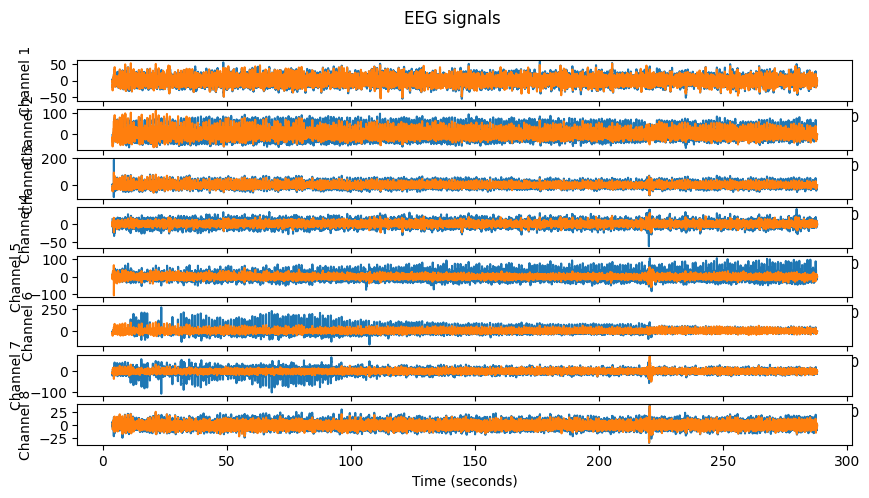

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
12.843543388794355
9.564154093169714
10.260227207756522
9.21052109990512
9.097813000156721
10.279401442497843
13.276885099981554
12.43215795122464
12.845993334918422
12.418507411748545
11.872171512790567
12.58971749291131
15.15763261967537
11.582814369953585
11.564433752581191
7.2386114460047395
6.7791275619779245
8.029363521359878
8.70238042603157
6.545887269108627
7.026752563135061
6.630771220525814
6.317139587823749
6.975801874900004
25.269819766158967
13.154237991867607
14.1884950737944
20.06275205242464
15.895062385530048
15.181267061813221
18.329811618489394
13.411431594485087
15.330107313095386
16.53568962829875
16.155475479730807
14.162821249101347
10.616741934283523
6.796414795127731
7.358728479869909
7.520145035208264
7.333369987302397
7.684038318963321
10.785650621055469
6.849750786561302
7.217708913704599

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


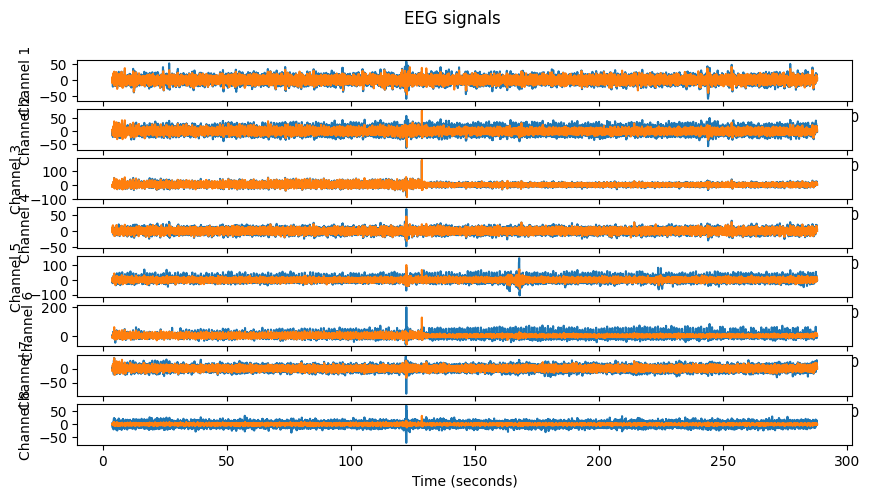

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
84.45212868459627
23.21223202933849
25.795482343072724
28.740882371448098
40.911945701564996
22.093158978762496
100.00564895240487
45.894269785302896
45.69333389447536
48.033060483060346
53.55849696552944
47.36245527996253
2013.0739876053285
10.516377378979838
12.38444964351569
15.550143227065103
19.71751670369368
12.963342453997894
1293.0628493643828
15.708297606205013
17.163288876354784
18.60008504590452
21.906852231837057
18.102710490681353
71.5355367965124
23.431459658515806
22.32347220089846
23.463001359438657
27.47905774704051
22.186012040821712
47.40989505162108
19.515191029460475
18.802590634693455
22.127516713985283
23.867030054447348
23.111572498938436
95.8620497834707
41.971272055708766
39.417465128982755
39.947866400706374
45.157988780065494
40.6030964790483
21.51397505831814
10.368008168847465
10.4537407

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


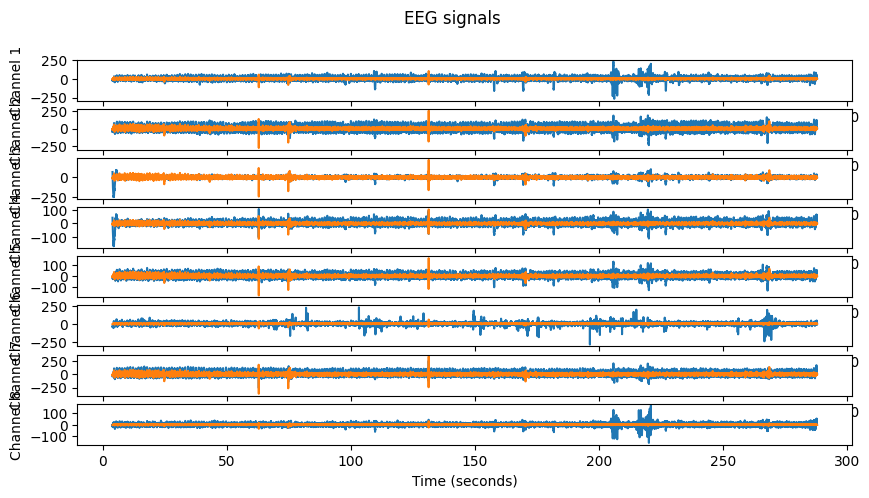

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
22.729329150338536
11.13000631341563
11.59775714725909
12.780211813210428
13.630512126975372
14.372472081036456
19.389169779170622
8.443606866091995
9.440478751605133
11.612564839670226
11.53801214239398
12.768216185191388
1280.6169302656144
9.003436314621116
9.741850130994084
10.099110528940408
10.325726426768226
10.368809942480592
1070.4392933006525
8.241964985127542
8.325834751620606
7.997865838927443
8.325790868717254
8.206104352895899
15.838874866631652
7.652854818549656
7.784369285350655
8.748295027352688
8.58476517128265
8.992168617442838
17.17400961617998
9.803996114266752
10.78920615807113
9.486565484596111
9.130129360854658
8.594018460528053
28.33965360549594
9.263309126891565
9.773221929171262
12.336168883955844
11.382311020940062
9.93050809099282
22.07309339570753
7.9194053425593545
8.49141822271114
10.92

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


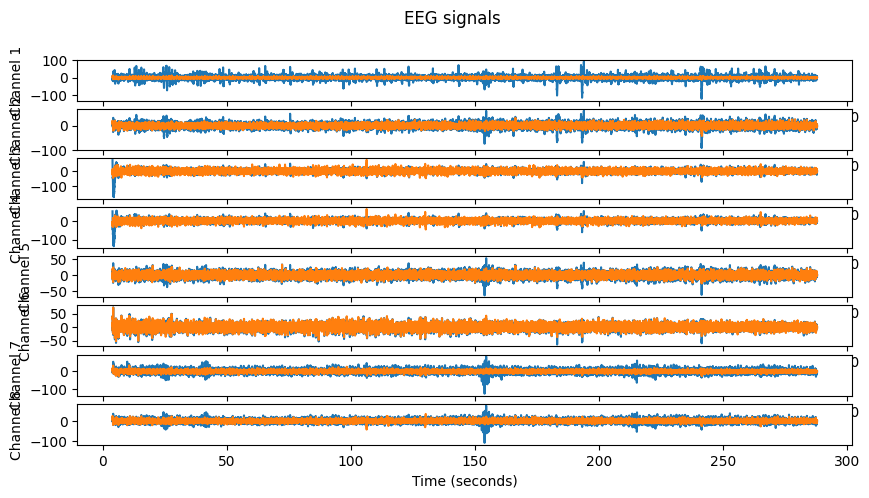

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.02240788175228
7.833099904569897
7.639586489176511
7.98048877674127
7.618787102546531
8.383709380700543
15.530176665356324
13.463572425500118
12.515519188697834
12.019907742479907
11.725147901755019
12.258047030932266
1148.3370564752333
11.477371859212587
11.458703788879408
10.774077543694563
10.255544379311527
10.36184093248149
1164.1183756122043
12.839945257172753
12.362683677956625
12.180625279012244
11.521962621239304
11.087766294951122
13.814663520521368
9.53265575852101
9.784703201566087
9.109763341972718
9.086475880000156
9.013435562350557
34.223277837298504
22.478875000180793
25.186665692030825
13.441565397498342
8.469316479797376
7.331865463077318
19.537388760080656
9.48350063850826
8.977754486763539
8.995278924267561
9.417191618026195
9.600577764311875
9.815282166250725
7.637748257122237
7.55501350172914


C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


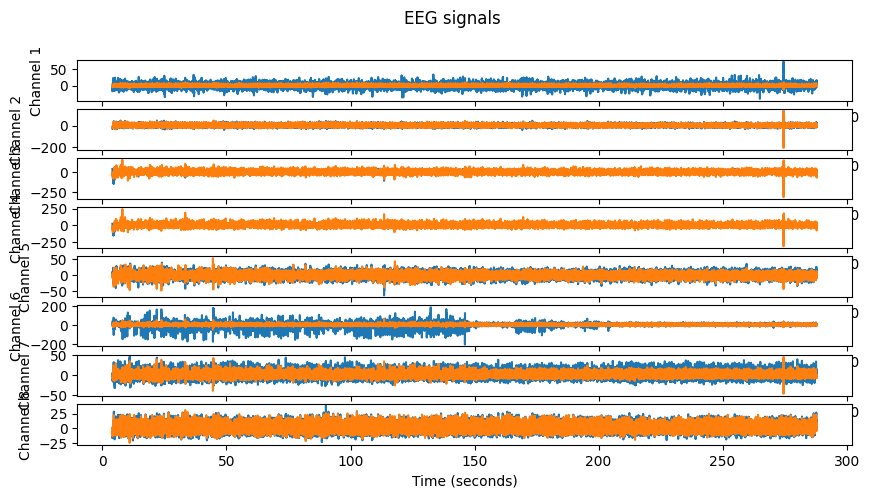

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
7.711011744970342
7.984739112834544
7.765361953903689
7.804248299806342
7.750776669790597
7.612886381063541
10.954623989134427
10.846570141207478
9.964717074729833
10.166710288502447
9.68952098766675
9.264273991201094
41.54934088317241
10.013397999582319
10.245445286114665
10.276502106719152
9.967528891004225
9.746415044134936
42.09773980523474
11.042102582590896
10.328168825869326
10.647881569330414
9.924974867465579
9.762086817826923
9.850152255719049
8.607481234154045
8.996502457349235
8.779973419529144
8.773275506133198
8.46308804470214
8.638966532351732
8.309261265498728
8.225275407262698
7.818401353182755
7.9285847089911705
8.9115402759303
12.823795643255057
8.60900325311822
8.288840507874982
9.050589100484324
8.835902367107161
8.830962387458039
7.327159791316564
7.018572623097848
6.490353570347949
6.3236867451

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


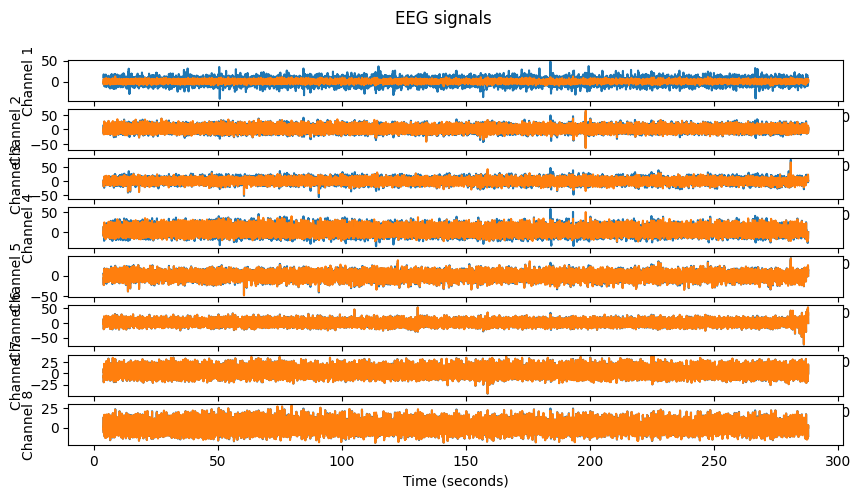

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
12.994522260017046
11.560836405125857
10.496895022699242
11.052925124015703
10.159831026450613
10.166014472472057
14.957908914559493
9.92492824442532
9.627117780279827
10.18114576052823
9.514203570680024
9.474457121197096
20.579530603512612
10.176409699319642
10.698044721121223
11.10786427024024
9.431809309016476
10.030199894135693
17.118159993253386
9.61709173851053
9.82969806196224
10.227389845650452
9.632192940149725
9.407684336814397
18.844252050427748
8.909893985114785
9.20395607041065
10.114646653891363
9.21377492357431
9.15416782689757
21.46192027194776
13.502743456228798
12.638528613176764
12.349126489255642
14.417651566397966
14.999190476495693
34.006563637602056
7.38702799140492
7.031005459413943
7.34187119600071
7.054049610960341
7.022537116575716
11.203981829593094
6.9834419232313145
7.565917661493352
7.7

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


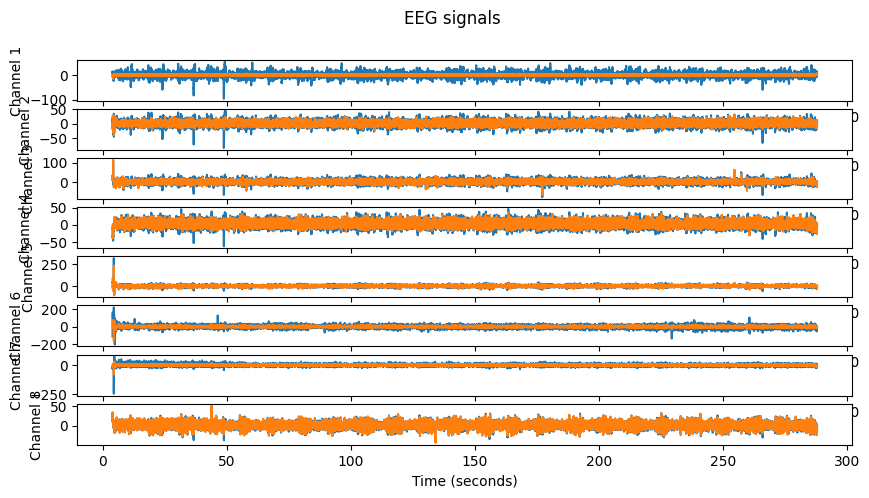

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
53.980740882547344
16.223769740633607
12.333002719685778
16.522659957398346
13.846418941880914
13.59675317300578
45.22954141494914
22.97816693001898
21.012941598900404
20.373737585074952
18.98509287931047
18.318246315207627
362.68892064867515
14.776442106445701
12.981311399778585
13.637950426107553
12.974668963298388
12.75951477390221
255.69718447616597
9.149265351610826
7.804750011840199
8.711351133442136
7.910098191959643
7.633965334151647
42.687472878426526
10.245283828575438
8.335500181066713
9.360017208709886
8.662944772656662
8.17824710900221
14.811375877211994
8.522771378060709
6.5990431036376
8.717002274012808
7.450633374486645
7.110335829764987
80.75975596393708
10.193925552328215
9.101124873371665
9.482719678062962
9.193102489412516
8.817777198726823
8.737483007689187
6.764840700045765
6.07073677432964
6.29

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


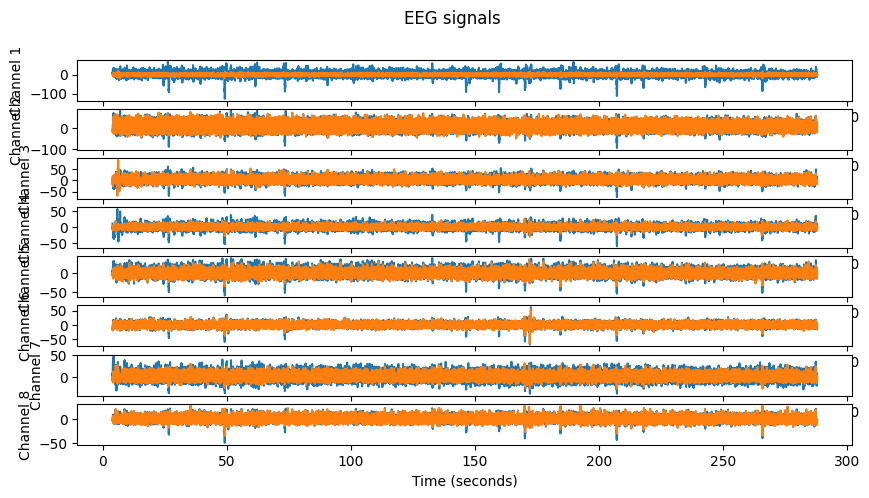

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
25.38534819099569
9.201889782381489
8.925132406803394
10.211062100184197
8.026648597812388
11.81243556678976
25.155968954238645
10.31824416690159
9.84670307585578
10.327038002543338
9.155597904315075
11.521996237560757
31.18201089013981
9.765440488753613
9.177709933685662
9.981218611455164
9.048293132950944
10.33919264745286
18.1917993536121
6.172767330195634
5.997529810037643
6.143852293723653
5.450783483485881
7.035116557889774
26.522982212201754
6.832481995967524
6.908236435357213
6.8603031259349185
6.288337732881329
7.307428862670937
13.552230415860475
8.681920748791152
7.342614439425084
6.940619198354759
6.7183509311062615
8.958980532125176
44.909254011941556
6.277496095884763
6.449434367801741
6.3669531455603
6.119906600468986
6.13023739704887
10.85968853127513
4.8906903716600345
4.766203904844495
4.59991840778

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


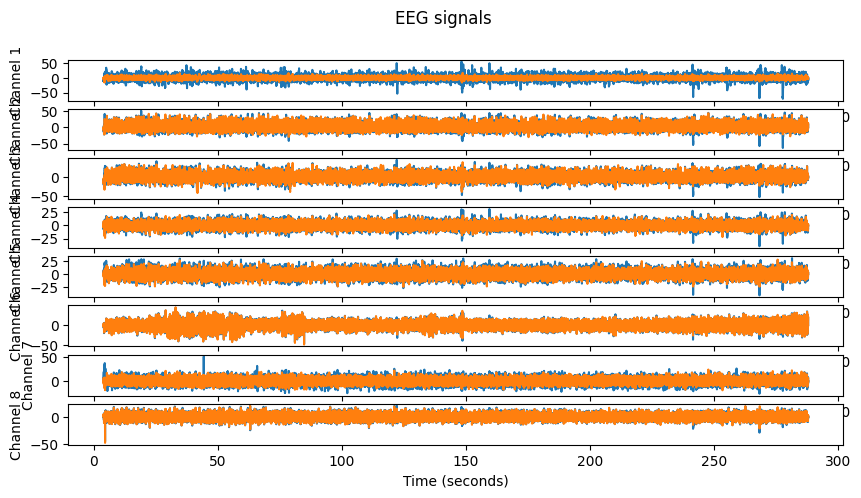

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.165993123074202
10.110203811015559
19.305190994186237
7.962892687172062
8.811601665226808
8.567020783940341
9.017574780070104
9.206177574675028
15.975505622447061
7.631081101268199
7.912091412734643
7.782577851833657
29.1351066660663
9.183838003646413
14.76535665573867
8.557289179535488
8.451073221409649
9.649492531692662
30.574024655391028
5.772696494261494
9.796222949632686
5.208943117243386
5.758897716508261
5.791723477643287
8.606079171170382
6.43861763552083
9.292614836683281
6.228714788237925
6.487897204072079
6.320906333669833
7.3085371923942395
5.596830601129221
9.335027858601011
5.788873494111558
6.577616538427276
5.637041859859068
5.039190396892304
4.971673470963575
6.811874991492807
4.915045232899867
5.140776162621478
5.124390149640828
6.900928445230592
4.2641651574560635
6.324116306564791
4.199134170237

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


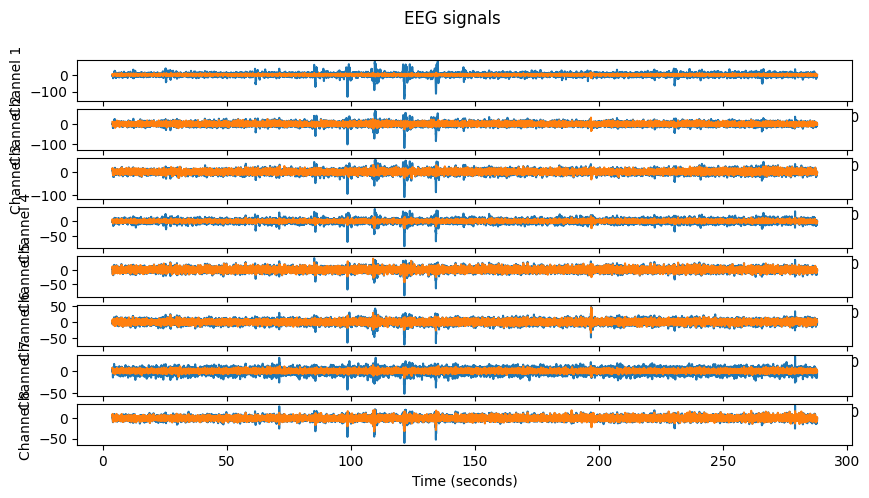

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
13.013555230135614
14.784600222817653
13.922007229243729
13.920440264457914
15.763849227647363
11.116671901453472
11.2657847152283
11.992112244391283
11.405493411069243
11.788981290937773
12.639691880761093
9.176737749128604
659.9629056387266
10.47040909703596
10.45000158543237
10.461041678709845
11.42256638150534
9.21207293792296
469.56862364937547
8.028416204877182
7.838191980268971
7.5835868429254285
8.484768424299869
6.56721032847077
8.331877124497662
8.120671620613843
7.71075347251046
7.52927223823282
8.394005910046491
6.930718983258373
7.243544857291955
7.336147318011644
7.071387914650947
7.110432153616155
7.862202575111333
6.337431648112189
6.903112326364584
6.030228776870499
6.16552320713424
6.1517209703244164
6.557592276646993
5.765276387203079
5.964452909249627
5.952180656030767
5.8757904619149866
5.7658636

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


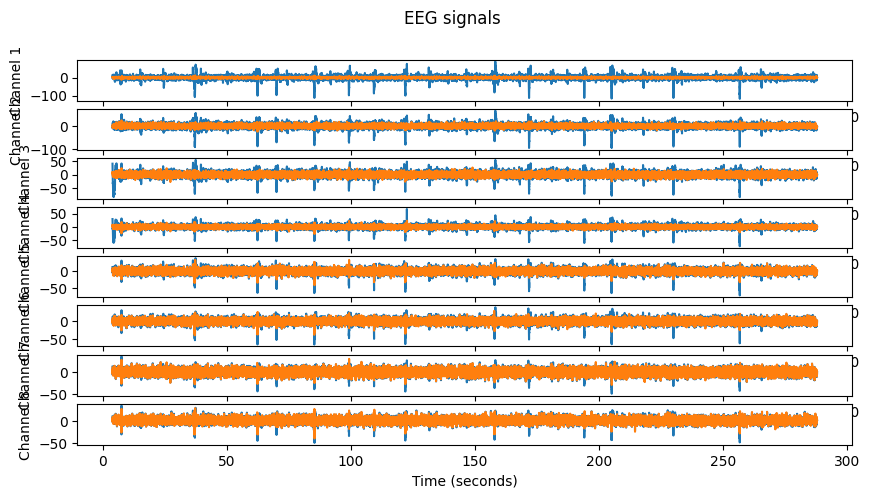

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
120.3253620608528
14.68374236605103
11.922309101789986
14.458142954127288
12.222923156621459
12.811424912616959
212.28723485295777
45.22243865806039
34.04269720220702
45.00124734141726
33.09297924956141
40.21621919333544
846.4573628030188
41.17984997771456
26.348039540164958
48.170394733998265
25.4206745481404
38.63489175926336
1258.5149666533816
12.235115804839328
10.40927767178045
12.290177236542647
11.566621810112077
11.341519565321482
235.41857909002164
17.631139555023886
13.25749036481977
21.020789306164406
14.933664601841773
18.789299440133355
84.34166474159208
36.812512563071834
33.883994808140585
44.70903796464548
34.59039362570994
37.722825653120424
41.63009231048759
12.697172099033274
10.253763179122505
12.864530588365838
10.442907276693473
12.196235054091956
17.780739097458714
13.565823333570133
10.9695798

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


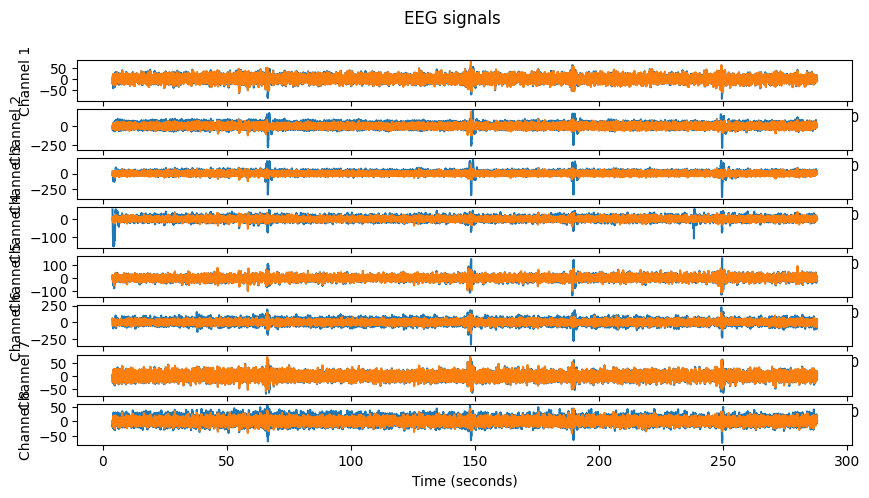

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
37.27461253013851
17.510231866244144
16.185958506957192
11.519566191775493
13.621724357544277
11.756387454063104
42.30241293183313
27.836432845945797
24.60181972736795
20.863957335164113
21.294706016124778
20.32697459689702
1884.4947057490617
21.66970871984326
18.179617157015137
13.399695092416016
16.002855011371174
13.827967476775406
1725.2903364712342
14.772408647366735
10.958668530367504
8.499498713113697
9.856339081536817
8.859390341052766
57.305273368459474
13.357375071941084
9.583927927605016
8.168680367622398
10.0165611500842
8.120987413239224
49.273847173889465
20.969828778541487
17.440501843166313
15.333264642523615
15.580764218667492
14.330397526960075
44.53558346065908
20.208628667343962
19.929915980857835
12.865990750478108
35.26776480227898
42.482245659089976
51.28607354750576
17.513863011835085
15.06928

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


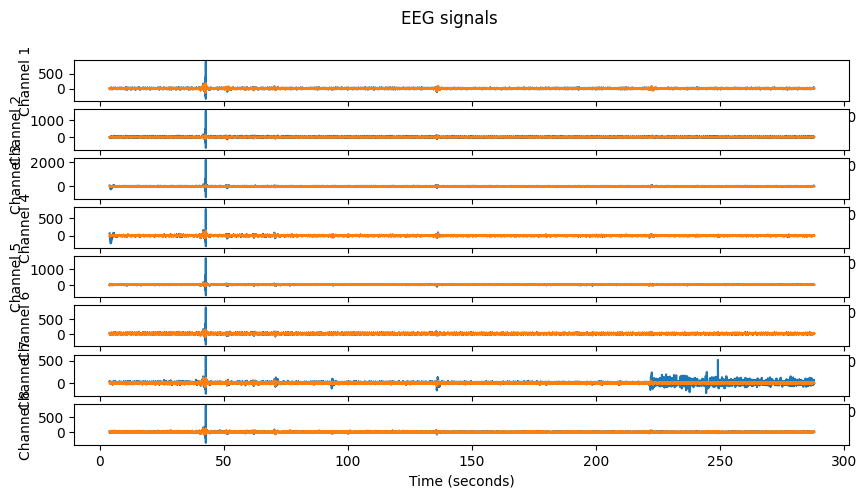

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
12.408087481406705
9.723158816891003
8.858489823104755
10.098853393430982
8.608733681654522
9.19502702412775
18.9929118669359
17.193369657702963
16.733387766370733
17.530732593760302
15.924614257623592
15.977386863380309
33.86567487125025
14.151637583765059
11.9434086430649
14.68576435000929
11.767283585007325
11.70394449351092
18.481094076652507
8.470141311854661
8.326366798611451
8.075122436547051
7.725825117226559
7.703252888150835
14.08325056735026
8.535497827148918
8.03160939615166
9.011248464277609
8.071163467706416
7.905256320082695
15.577510907080018
12.408970342574325
12.023549180989052
13.351808195301086
12.271026597506443
11.102746499000606
23.03622529676313
17.024524545098767
14.465007399315484
20.385714701776614
13.72122109231533
10.258307623998007
14.082581092306052
12.17905658487544
10.896279646386038


C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


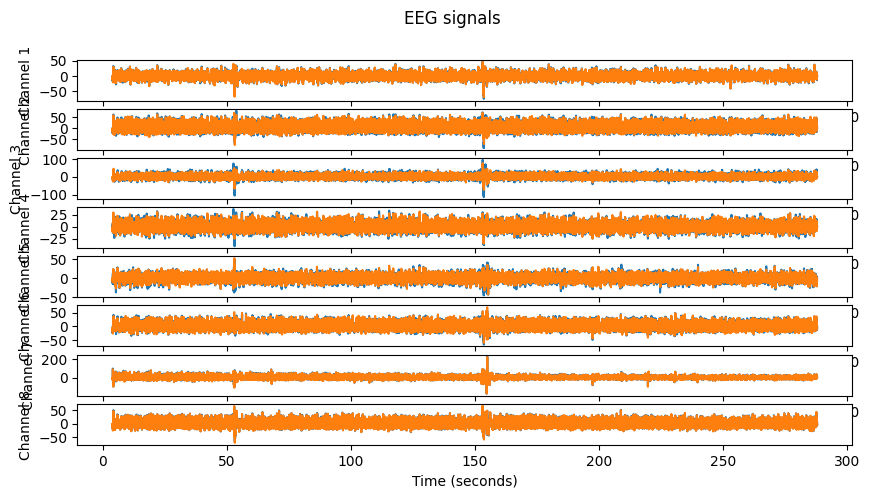

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
8.456339708329223
8.408339283045319
7.566072286733126
7.98224563965194
8.436075770028046
8.083297714938883
15.423152936938088
15.168439864705471
14.494842658580305
15.25753807563602
15.162686504927207
14.52499759431914
15.039832967255668
12.673706118558075
10.710086394469855
11.16114998431429
11.172623377711838
11.023477920519339
9.297259906607122
7.556905588074596
7.222802572951663
7.4758706721120864
7.591993727728183
7.3099732724189606
10.279312460312447
8.317702111746954
7.224130745188284
7.84182898813324
7.8670106677477945
7.647614647774953
11.310334948680982
10.574432318743042
10.853377810874443
12.045286900634942
11.113347483032014
10.4556568544375
11.932403080259169
11.385290459176023
10.372909054192798
11.09850194626883
10.382629766901893
10.076965012378066
9.894001761345981
9.493864852302297
9.12738669703332

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


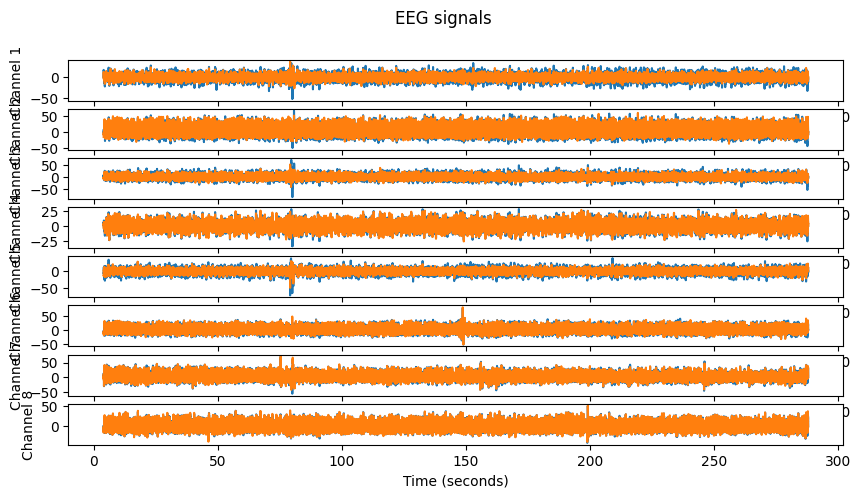

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.214284922981411
7.0136402525489485
7.641708339992925
8.267638977222498
9.075143253107589
8.552390651779481
16.168508434901092
13.732678155104157
13.960823881590894
13.694408341803133
13.91893183174927
13.25463836250876
15.1060814319327
9.899348509608883
10.096227943937944
10.349839914282763
11.003098080317985
10.094440846194628
10.505822529980644
6.9390041630014
7.191105707485876
7.033654708628139
7.223970974393262
7.031947832284736
12.08502954140384
7.992719718477394
7.553244041074627
8.218627287950234
8.145693562856296
7.731948739268479
11.875953548924128
10.072664377517798
10.272664087549417
10.3005251439932
9.624354948112545
9.149057204716815
11.018077678904755
8.643690831152382
8.897000561844305
8.73405008189481
9.426884457112248
7.613058408490077
10.039518993685972
8.385670720175666
8.52544925243997
8.3466542

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


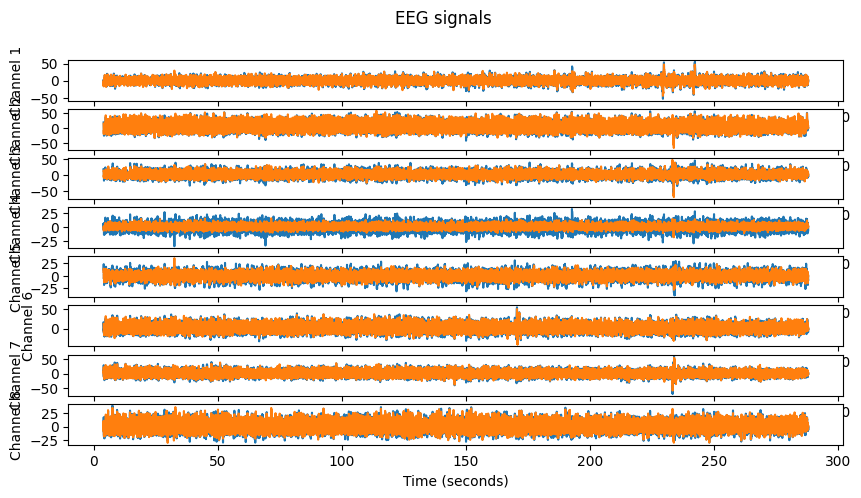

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
8.436844386813624
7.723660128476626
7.099898336128405
7.56112339773005
7.022864192128472
7.84792709211239
13.603595235291227
13.728924745464063
12.741661871509013
13.26442582555077
12.493884878515008
12.85573259808786
1227.6551404964616
10.680119471932215
9.189303546776477
10.335660877962122
9.37195620136785
10.618083428863914
876.990397272407
6.75993820222078
6.028582790835627
6.380105635501678
6.614862422387339
6.464604321002553
15.650395733684434
8.722290094864965
8.915514746114713
8.533450842946763
7.452511639921972
9.189605326362772
10.566228596552449
10.15652947523829
9.894901239637347
9.991256488510233
9.203236073624003
9.921841199340417
10.298141367158541
12.902093647014697
15.028727235062354
10.689326135284462
8.596616692880326
9.958879804166791
8.081781462391767
6.862867360174947
6.5846527738863525
6.625570

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


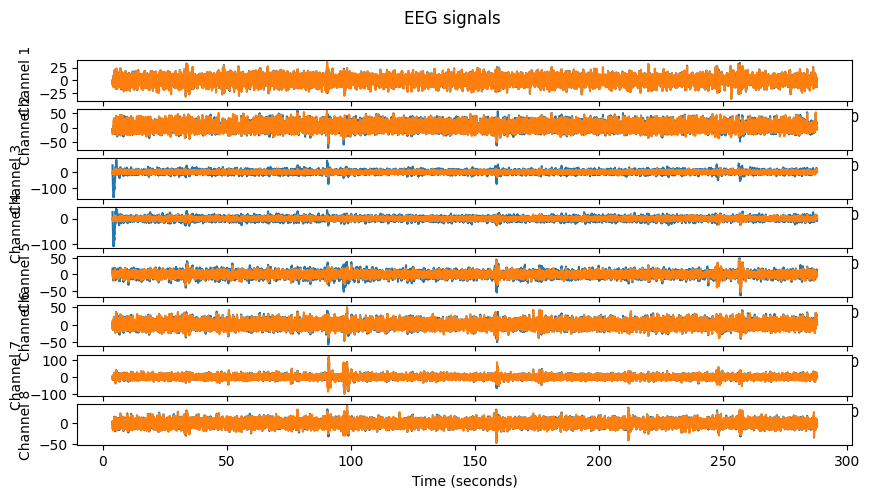

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.270119050232964
7.471435237679421
7.180079086461917
8.817155772237435
7.772372643591815
7.874558171826872
12.415994400964522
11.702161322518915
11.957628301336728
12.831651386383198
11.813740919386202
11.924845249041095
958.0480997143819
8.669453496851627
8.986703284480514
9.745110076352658
9.097088130407126
9.575269220693587
686.6420549376775
6.0094873656508705
6.213031611897345
6.7568474190258785
6.5321377258024365
6.725422788297948
10.588020020972017
8.932953846992099
8.614463247002835
9.194867453100034
8.49168954067938
9.11490677611147
9.296527442429307
9.612788505717104
9.741917384125216
9.919898238381093
9.128155353133208
9.890905122636564
8.442709439812768
9.517113905693103
8.77684988940581
9.560161622364348
8.173581848009716
9.35485785204292
7.0807933081620344
6.934667957987501
7.127293599889814
7.389889122

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


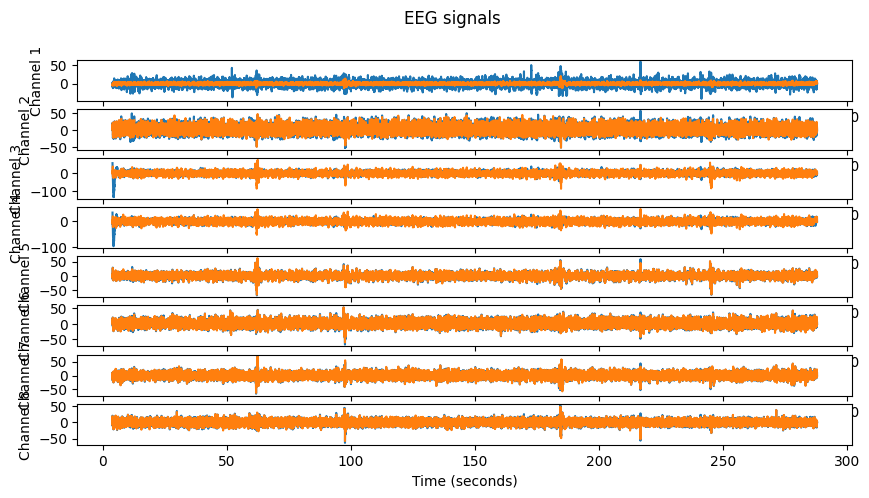

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.424508759849658
7.7126470342967135
7.141788673239117
7.776320233843422
7.603510988318764
8.032525716650131
12.354147401169548
11.33097618429334
10.502937850275151
11.196821158294075
11.02069947281699
10.895040920592901
52.28879047295583
9.388679975939391
8.271119875395488
9.17132675857166
8.677573374891795
9.669811955124345
36.56598468239707
6.237270588655365
5.946652204488217
6.353730884703942
6.443967425999945
6.545893398524287
10.95363237806638
8.341656891690377
8.094283466608195
7.836289104919987
7.925689185875133
9.75170118402563
9.588102798482566
9.124916414012226
9.100458398645602
9.796392956315827
8.815428497182754
9.39522815859395
8.356538961769289
8.08233218136295
7.453479239689998
7.861418361789348
7.0146168056225875
9.398987567646241
7.437783294596699
6.697431080491974
6.20018073170541
6.205306574266391

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


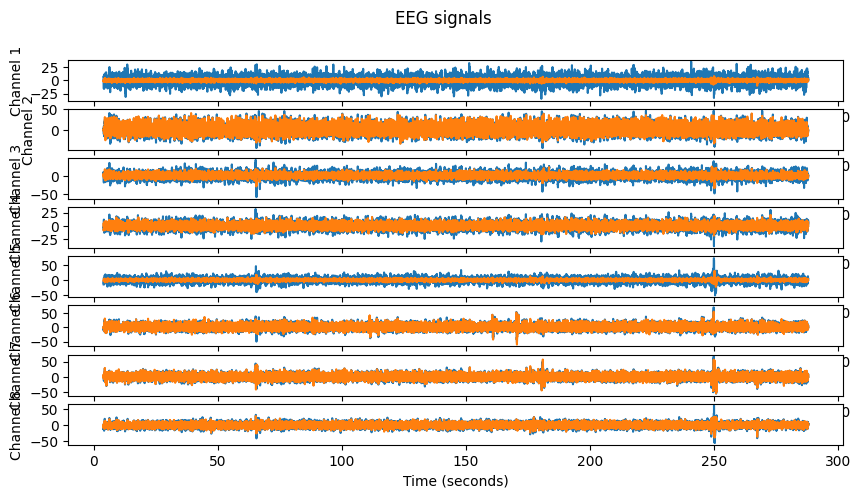

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.204358378442308
7.748187254240948
8.267694036482736
8.51609486885197
7.637789443813232
8.747326049145794
11.885921809434059
10.340837017587218
10.77242816749104
10.585095165350674
10.196712407706345
10.790098098671876
14.695165609737435
9.442113720861764
9.893137886929145
9.460609117061805
8.932523087650793
9.648879846409379
9.49498771429526
6.311447127573631
6.802879991025152
7.1977537534332505
6.526814160609607
7.209474490037647
11.158079575104841
8.457848995261696
8.797379652874707
8.44663446664355
7.841248450648249
8.886671149565126
9.227447241584551
9.2739356683254
9.479311611812394
10.336170013146806
10.007839193785188
9.402671900194768
8.989479237187865
10.09113970835701
8.228469038591449
8.87700421195028
8.820649353563764
9.378101019464356
7.820695383814486
6.819395312031856
6.940871407248547
6.912806102072

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


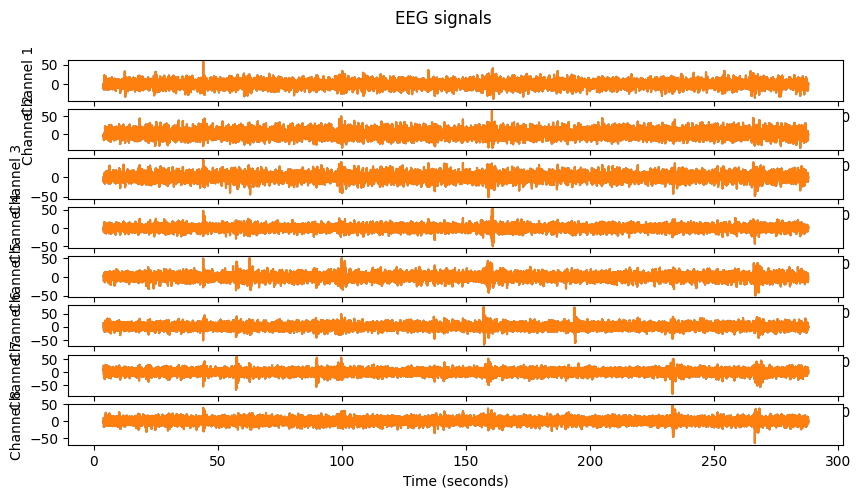

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
27.878952565394094
22.530398828755448
21.071261075488103
22.47291337841536
40.99098348224394
160.6026190395887
15.081789322894709
11.526875228276086
12.878247605900084
12.764258335722921
11.166060111580151
9.982181187045034
452.0793988791663
12.009970000429226
13.38510643596369
13.394104118685364
11.719191452508618
10.663817976146444
414.9893915778679
10.485981444258202
11.992035272324964
12.209748418329749
10.007977677147016
9.207690011135377
26.871006192116603
10.13893011190725
12.076488590845482
12.096738889374262
10.059119076762505
9.608891301512266
19.279219032046157
10.043735363187679
11.189914328939727
10.83128973666796
9.268873995306182
8.976204197151272
11.322922632413265
8.726441384928584
10.073291891911754
10.107610892176192
7.926933531553482
7.645349700020339
14.07917970925621
12.822205661058039
14.099616

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


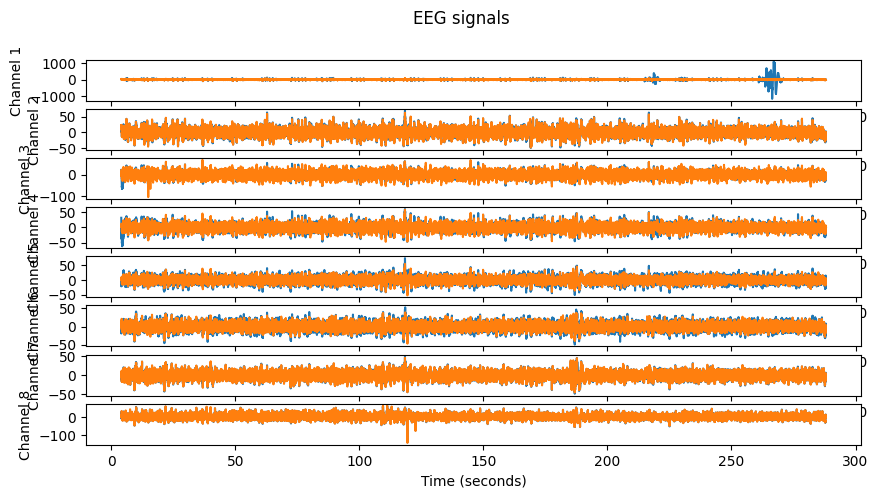

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
22.521626877425255
23.342074652524662
22.847479916540554
19.6353519679234
22.231550297198297
21.573738040336853
11.131519392936442
11.335755265648322
11.22021222217891
10.665179318020355
11.682291243748173
10.862370847434093
16.03863312658694
11.520521501565831
11.883363850024036
10.965434456199405
11.825457868110988
11.049708159663465
15.099054393211839
10.194042896183822
9.976880167761221
9.162210818576424
9.98036598767659
9.695927972518968
12.147010582815621
10.240982857904855
9.456966166117265
9.382243630010917
9.886376123549994
9.760122166432845
10.942450572553845
8.751634305661348
8.48419848420842
8.920606263558906
9.100808323249632
8.620850541290858
8.618496560432538
8.21738304746367
7.823524000049496
8.381311751318616
8.490021093404064
8.249525273776067
11.710463916742842
11.14390016900402
11.339784828295787


C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


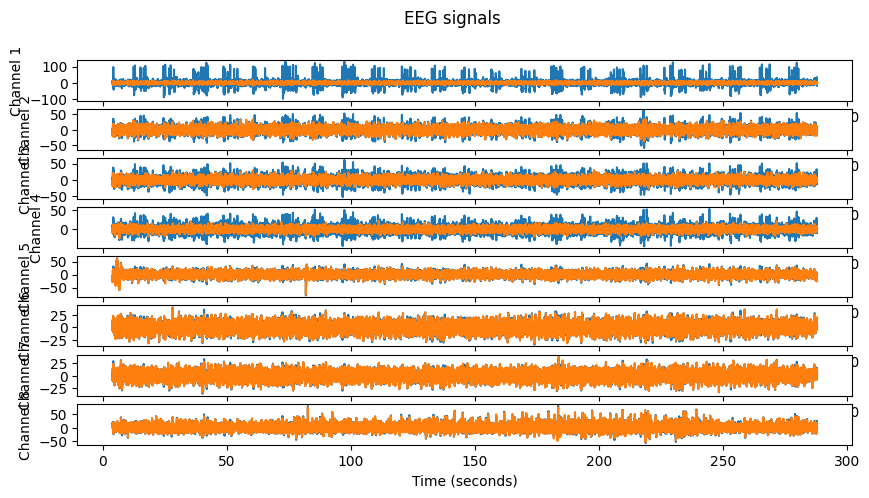

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
22.083456995079874
17.69097181862796
19.64199600964914
23.358122294686147
21.676420300145686
21.332501276864438
12.84626208541315
9.868783051677395
10.210977631854488
10.99497188397391
11.418770199203014
11.072433823585058
12.104664965655774
10.278104958975259
11.161816914987567
11.351105658587699
11.444647285776057
11.690191865980072
9.850409566649695
8.548837474255974
9.279157492735706
9.975412731175812
9.485929140656932
10.12154194949649
9.726107877486085
8.980992695666998
9.260967062285527
9.7175092191449
11.57365909934199
11.094512486050268
9.601465373706258
8.067629561523207
8.30279261748612
8.924464171293607
9.501694925371158
8.767783095059633
9.03303225682435
7.15282283280721
7.4853535777295646
7.861423544239143
8.340429051858163
8.265396577084095
10.75605539483338
9.003838138288648
9.21530877384555
9.6628259

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


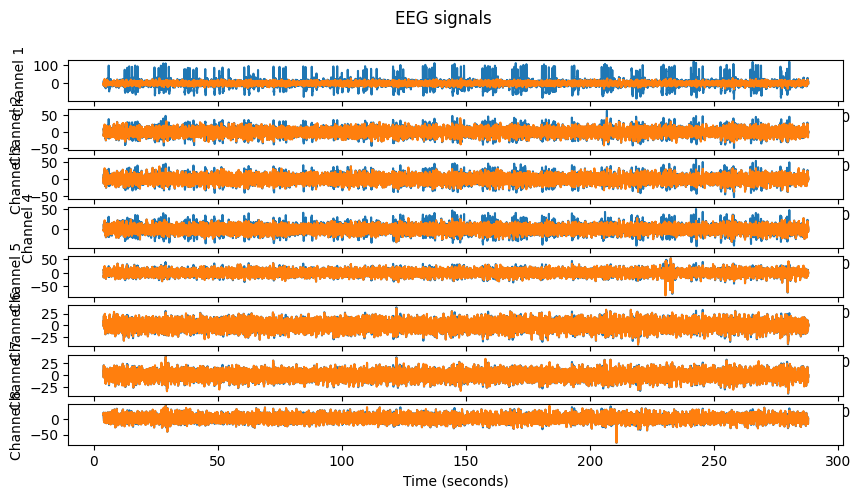

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
18.439440956888138
20.21071324731109
75.25811473567944
22.83741475037972
21.35155611402387
21.85568545378053
10.367516277522672
11.069780488180958
12.823516676917203
10.765009516989858
10.505572186866074
11.021022106731431
10.701852917683327
10.904459927098117
11.59968191083557
11.117756789257196
10.862109778173199
11.166449312276677
9.37481611530305
9.484721911847277
10.071815565683679
9.64256752125803
9.626164227215767
9.67760429417681
11.391272482444442
9.478752686966084
10.634332136638578
9.56286347056614
9.681607957379912
9.201677113977908
8.809984071563361
8.8572074583633
8.66370988674394
9.262377427793046
8.988681040229192
9.21049891138509
7.974423983057819
7.773554274648168
10.307000325552522
8.473888412424921
7.764319277222324
8.005128092102993
9.857196965054971
9.297042121128815
9.10576668897371
9.308783090

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


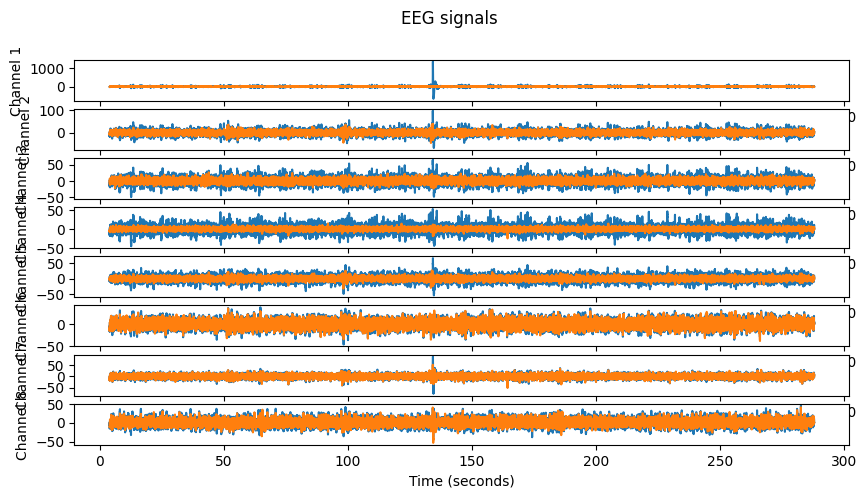

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
18.909009968305252
21.478890978609776
22.43402831404602
21.925869573298147
23.422206914087113
22.6788111829493
10.472105750185301
12.450599869876886
12.021563880557153
12.564307574228724
13.274229706513912
12.953218949494277
11.398947597891105
11.802756182229523
11.107102518196017
11.54917633339845
11.944502254060938
12.272656985366678
8.779775847900178
9.551257492060666
9.499905000347438
9.802093140482778
10.010654679948573
10.1500575786342
10.256127799417012
10.42989628175161
9.873636471611423
9.890710789590283
10.067918545934033
10.35262036603415
8.629355361704032
9.276591935000326
9.734730621265998
9.89225717732101
10.507657607667824
9.634003143494215
7.552041403276248
8.619971657707977
8.419157486279737
8.772594534132619
8.647867528624777
8.147576429531844
9.17295461873288
9.14310435151367
9.191767267724895
9.75

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


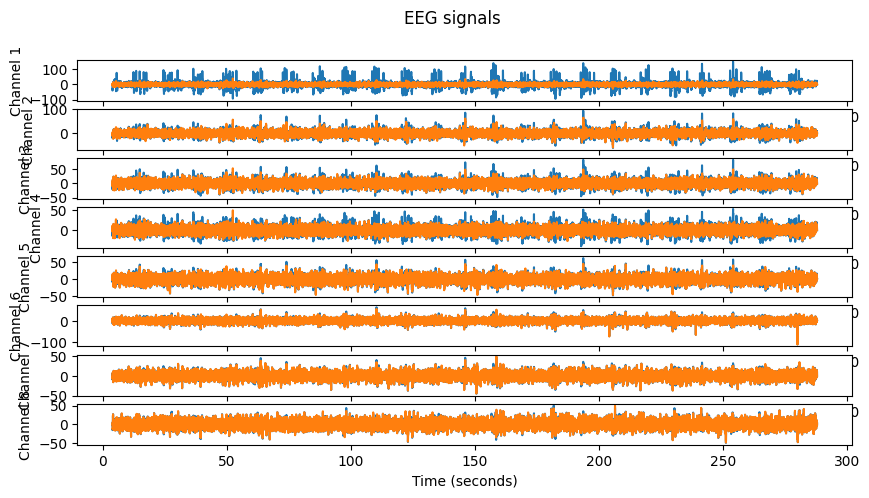

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
16.815616954538456
15.673707077226299
15.89414958259687
17.09557697177092
16.210091778829575
17.14204886841415
9.893002068173988
10.05869746906229
10.174675368655178
10.55101589909664
9.596012275876484
11.793310118633325
11.626404962293627
9.990045613587947
9.927622700278583
10.311515450676236
9.864329735965734
11.027397500416335
8.673142108658288
8.520762829180462
8.320681037959517
8.885111505696218
8.401564314704336
8.560909503884416
9.901110730984538
9.62503849349285
9.42682886267228
9.428404123255879
9.479294775669409
10.474779510122476
8.635393780389688
9.320640675777332
8.545661258125
9.791025505901938
9.132182107732014
9.673799568332743
7.624820250387529
7.393538625480138
7.535009315987795
8.347402717531944
8.457863427369789
8.495560982534498
9.018602949263867
8.833038936176958
9.086438747095187
9.529741638295

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


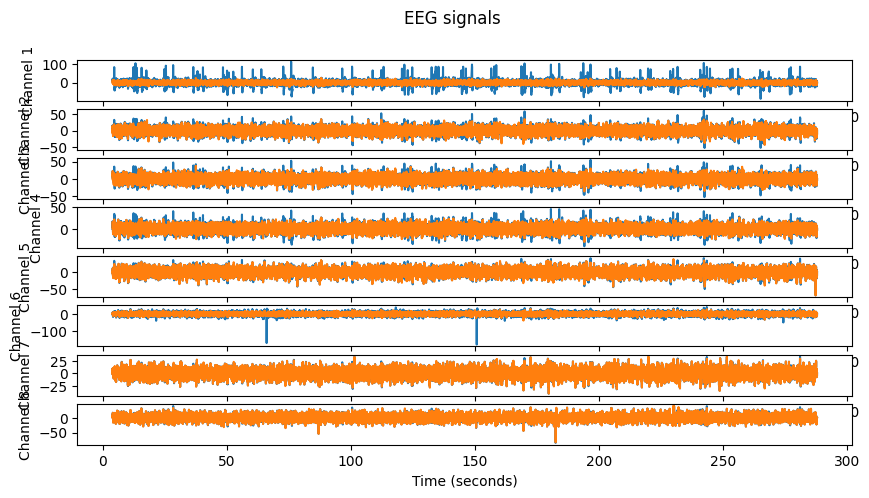

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
20.335482050607347
23.19393987430905
17.087303302902974
18.68936542106788
17.026246306407543
17.123911579182735
15.725510701768057
13.820527552816761
10.152928780271013
12.256445665260328
10.511556922131387
10.771056175004803
16.32844311697402
12.168403869398007
9.946222125548964
11.277412613574038
10.560772066871186
10.637255435932689
13.322343113110279
10.603278600792288
9.088413171507002
9.417513329044642
9.262305742543601
9.384218911264737
15.43508635103798
10.694292103745118
9.002420035280522
10.198768668718737
9.729350056719714
9.60599779103445
11.341980535351937
10.530532250665265
9.218356647008799
10.092401084640953
8.585255907890504
9.824471959768827
12.932173387905445
8.93815721480425
7.594346213098783
8.256808898195073
8.000094450144765
8.110153603986925
11.031498502093305
9.825636838623021
9.2016635811192

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


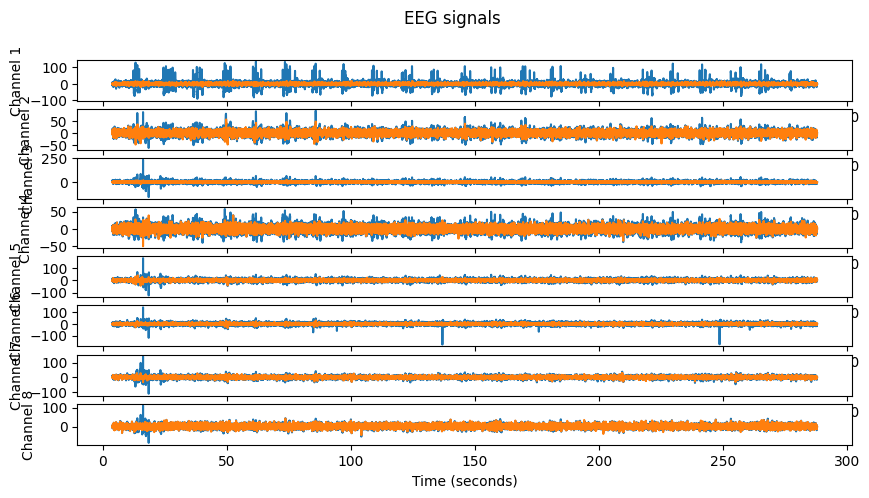

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
14.195951517425568
13.122658622576296
11.607055998611116
10.73239226328298
9.616443249709702
10.792784403965774
18.08266984646243
17.95704380551735
19.14736917031917
22.968076189928315
18.500255795899832
17.52169020035741
47.61929642675208
8.92680168617199
8.476141680102366
8.81670787617304
7.575066531648136
8.134658860009823
49.96566761770382
8.7677107318814
8.170679193778263
8.480577113551181
7.225582582008961
7.6635115488515595
11.934977100509732
12.316271986217235
13.547696748242501
23.011861827500258
12.896517031661729
10.68925729929798
10.858219809557989
9.365946820792178
9.49158193581959
11.288433432042918
8.726796559384457
8.799847734718568
8.974651255141811
8.587405265026346
9.12666443637943
12.867856974631529
8.696255996004266
8.05850620280373
12.36017798674062
12.827579022512769
14.701930809989495
22.33177

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


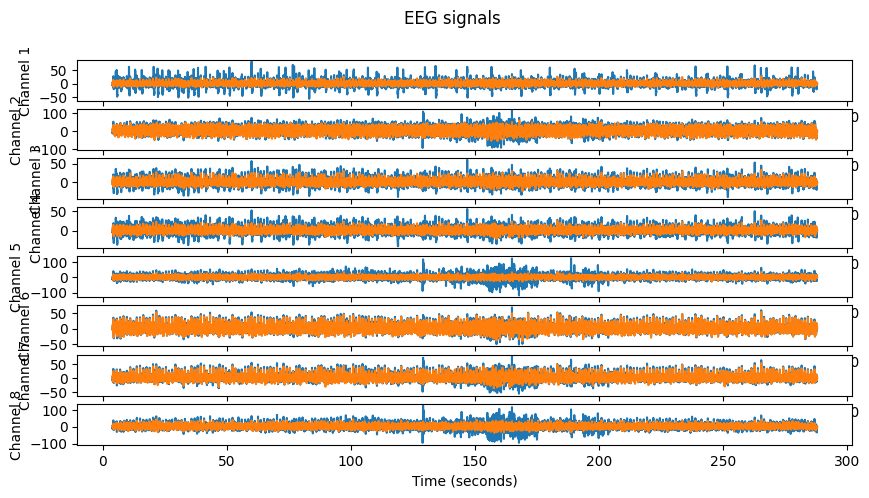

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
12.241182700415594
13.549306470074999
15.04760587505432
14.907300612619904
10.575670206473951
10.804580834560243
15.737862513171123
16.203308285167715
16.91086989211075
16.979750011524768
16.095708460023875
18.319680797822812
13.985246150057613
8.632769024853097
10.079738765477819
9.822530680615378
7.801071718103504
8.130106400564715
14.047283259687251
8.788146420052316
9.672441206822256
9.61177385727977
7.49223906459726
7.574236396088279
11.071141021699008
10.03958991960383
11.582959172350499
10.587006503172036
11.060520141851905
14.093299990562608
8.882296357706704
8.573149824530454
9.54456771243251
9.230930549611715
9.041959708467605
9.050834886627642
8.63603825777893
7.589204489922576
8.329850898302904
8.04590456830223
7.711281070650057
8.745191425410868
11.475961557148063
10.503074154953826
11.30162835563437
11.

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


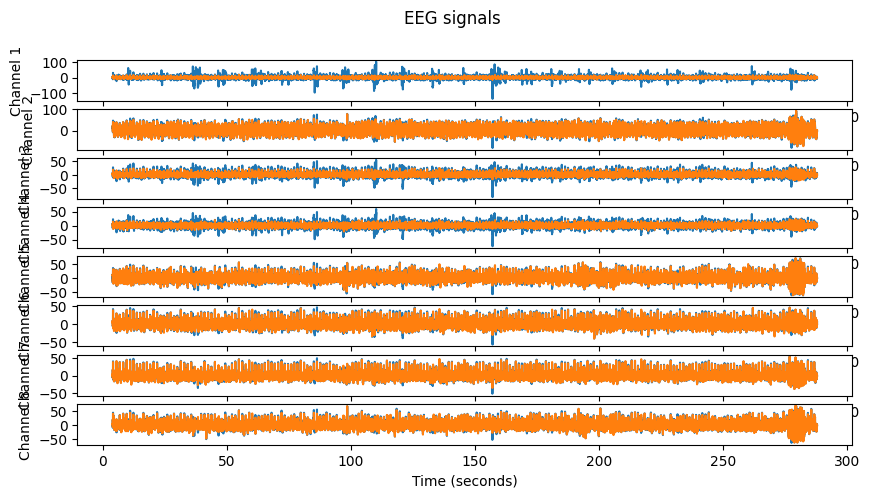

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
29.942683925794764
10.787675060063364
12.06090710327995
9.86044496015023
10.043926551791039
11.4787870459529
68.59540692883682
15.256659750102395
15.374314400876614
14.627755439248421
13.273111029851762
14.715153461079641
58.140218196539
7.484838543200512
8.016647950838875
7.519766286726807
7.512916918468867
8.212064674595194
44.94894066379594
8.8297533836066
9.300392749262132
8.719875709194458
8.306344103222694
8.714075089574617
82.00153986872793
8.93560677698729
9.31340512476731
9.358261083928914
8.399463136174173
10.196675994108661
64.60260882728728
7.994425454840963
8.021103958934079
8.130674777413699
8.149785689075582
8.9854622453277
68.3774900916309
7.726560254678131
7.723855074071889
8.005287859680879
7.515890453670889
8.177329965184164
102.60556090977556
12.97630939176322
13.437010654642712
12.666647166563296

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


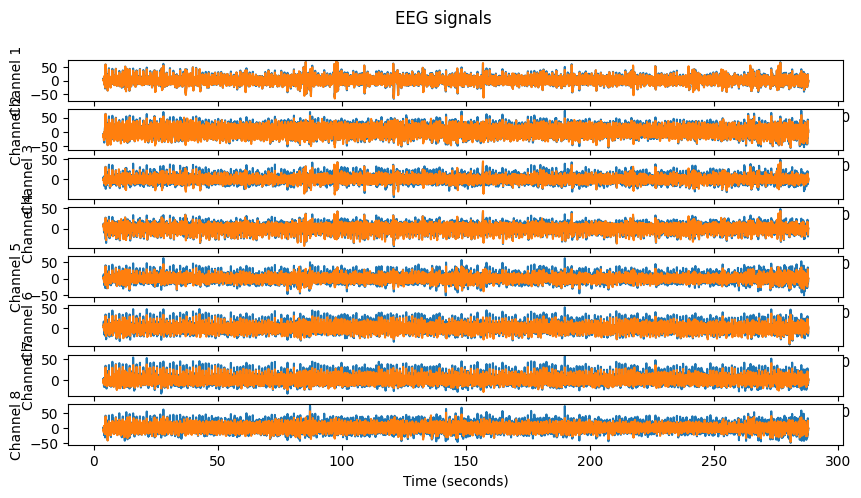

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
11.660338134979698
12.700360558344606
12.039077566293015
14.019805098903884
10.413015520427068
12.215357943768465
15.599909292775749
14.60931417407674
12.650594362797245
20.403802605924678
13.424176452277651
13.890027750382405
8.731548437567366
8.271179686131727
8.399119798462243
8.543080835618731
7.8271882862418005
8.696383518956607
10.463320242562586
9.309735737385855
8.678496306844
9.00551583733882
8.100223638116624
8.922939439465521
10.702308825739841
11.156049052241585
9.177791125120486
16.108290404435085
9.825396924044178
10.31290246544619
10.793324423756031
9.440900632930973
8.91641367173027
9.992094266154101
8.96968090182292
9.172116649312375
8.664419219009352
8.52975283450787
7.538427961169905
9.82184175251125
7.555368756081844
7.879788414417391
14.000990686114102
11.864059333348246
9.93713591352373
17.42325

C:\Users\JackC\AppData\Local\Temp\ipykernel_19140\1234465146.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title


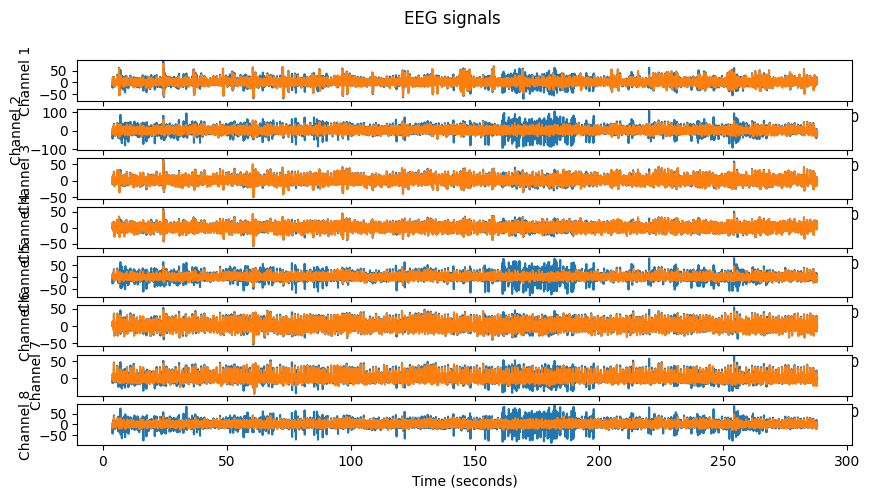

In [21]:
for file in filename_list:
    ICA_filtering(file)